In [132]:
#!pip install transformers
#!pip install emoji
import emoji

import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

import nltk
import pandas as pd
from sklearn.utils import shuffle
from nltk.tokenize import word_tokenize, sent_tokenize, wordpunct_tokenize, regexp_tokenize, TweetTokenizer
from nltk.probability import FreqDist

from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
import string
from matplotlib.pyplot import figure
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from transformers import pipeline

From the google play store we have scraped reviews for grocery store apps delivery apps: Tesco, Morrisons, M&S, ASDA, Aldi, Sainbury's and Waitrose. Parameters for scraping were set to 300 for reviews with 1 and 2 stars and 250 for 4, and 5 stars and only 150 with 3 stars.

In [2]:
app_reviews_df = pd.read_csv("src/reviews.csv")
app_infos_df = pd.read_csv("src/apps.csv")

## EDA

<ol>
    <li>Check the number of reviews scraped for each company</li>
</ol>

In [3]:
apps = app_reviews_df['appId'].unique()

In [4]:
def check_reviews_per_star(df):
    apps = df['appId'].unique()
    for app in apps:
        name = app.split('.')[1].title() if app != 'de.apptiv.business.android.aldi_uk' else app.split('.')[-1].split('_')[0].title()
        print(name, "reviews per star:")
        stars = df['score'].loc[df['appId'] == app].value_counts()
        total = sum(stars)
        print(stars)
        print('Total # of reviews:',total)
        print('\n')

In [5]:
check_reviews_per_star(app_reviews_df)

Tesco reviews per star:
1    300
2    300
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1250


Morrisons reviews per star:
1    300
5    250
2    119
4     86
3     80
Name: score, dtype: int64
Total # of reviews: 835


Marksandspencer reviews per star:
1    300
2    300
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1250


Asda reviews per star:
1    300
2    300
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1250


Aldi reviews per star:
1    300
2    280
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1230


Sainsburys reviews per star:
1    300
2    300
4    250
5    250
3    150
Name: score, dtype: int64
Total # of reviews: 1250


Waitrose reviews per star:
1    300
4    250
5    250
3    130
2    115
Name: score, dtype: int64
Total # of reviews: 1045




From the reviews, Morrisons and Waitrose scraped less reviess with 3,2, and 4 stars due to availability however at the extremes (1 and 5 stars) it's the same as others - as expected. As we aim to extract recommendations, the 1 star reviews will have vital importance however we proceed with cautions given the lower sample size relative to other apps.

<ol start='2'>
    <li>Check for missing values</li>

In [6]:
for column in app_reviews_df.columns:
    print("Missing values in", column, ": {}".format(app_reviews_df[column].isnull().sum()))

Missing values in reviewId : 0
Missing values in userName : 0
Missing values in userImage : 0
Missing values in content : 0
Missing values in score : 0
Missing values in thumbsUpCount : 0
Missing values in reviewCreatedVersion : 762
Missing values in at : 0
Missing values in replyContent : 7963
Missing values in repliedAt : 7963
Missing values in sortOrder : 0
Missing values in appId : 0


In [7]:
app_reviews_df.loc[app_reviews_df['reviewCreatedVersion'] == '19.29.0'].head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,newest,com.tesco.grocery.view
1,gp:AOqpTOEALmLSsWoRa5iIEtmENfRtPkvS3O-W7NvitLW...,Alistair Charles,https://play-lh.googleusercontent.com/a/AATXAJ...,Rubbish app. Forgets changes to orders.,1,0,19.29.0,2022-03-30 21:37:56,NaN,NaN,newest,com.tesco.grocery.view
2,gp:AOqpTOGosMLyacp8xUArioSjY5_628L0xxBJ3BmgTtC...,John Hirst,https://play-lh.googleusercontent.com/a/AATXAJ...,"Rubbish, constantly asking to resign in",1,0,19.29.0,2022-03-30 17:31:00,NaN,NaN,newest,com.tesco.grocery.view
4,gp:AOqpTOGsEOuB5kASf1CwHBp8-DfEzUIjwppVtIJJL9e...,Hey Boo,https://play-lh.googleusercontent.com/a/AATXAJ...,"Got to be a better way to do it, I search for ...",1,0,19.29.0,2022-03-30 08:11:54,NaN,NaN,newest,com.tesco.grocery.view
5,gp:AOqpTOHbEWaEPaarmEliv8pp21O7EmHJ618AM_Etw9b...,Stephen Wren,https://play-lh.googleusercontent.com/a-/AOh14...,Negative stars! World's most annoying app. End...,1,4,19.29.0,2022-03-29 22:11:17,NaN,NaN,newest,com.tesco.grocery.view


Further inspection shows that 'reviewCreatedVersion' is the version of the app the user reviewed. Therefore, we can potentially narrow down the comments by the version of the app rather than dates. Alternatively, I can use the date as a proxy for the created version so will keep those. Regarding the replyContent and repliedAt, doesn't really matter as these just represent whether the company replied or not but worth visualising just in case. 

In [9]:
app_reviews_df.loc[app_reviews_df['replyContent'].notnull()]['appId'].value_counts()

com.waitrose.groceries                101
de.apptiv.business.android.aldi_uk     25
com.marksandspencer.app                12
com.tesco.grocery.view                  4
com.sainsburys.gol                      3
com.morrisons.mobile.android            2
Name: appId, dtype: int64

We can see that waitrose is significantly better at replying to comment, with the next company being aldi (a budget supermaket) surprisingly. Aldi, on the other hand, has not replied to anyone. Next questions is, are they replying to good reviews or bad reviews?

In [10]:
for app in apps:
    print(app)
    print(app_reviews_df.loc[(app_reviews_df['appId'] == app) & (app_reviews_df['replyContent'].notnull() == True)]['score'].value_counts())
    print('\n')    

com.tesco.grocery.view
4    2
2    1
3    1
Name: score, dtype: int64


com.morrisons.mobile.android
4    1
5    1
Name: score, dtype: int64


com.marksandspencer.app
2    9
1    2
4    1
Name: score, dtype: int64


com.asda.android
Series([], Name: score, dtype: int64)


de.apptiv.business.android.aldi_uk
2    22
3     3
Name: score, dtype: int64


com.sainsburys.gol
2    1
4    1
5    1
Name: score, dtype: int64


com.waitrose.groceries
1    56
2    21
3    19
4     5
Name: score, dtype: int64




Waitrose mainly responds to low reviews <= 3 stars with most of the responses going to 1 star, M&S responds mainly to 2 and 1 stars, morrisons loves the praise only 4&5 stars. Aldi no reply to 1 stars but only to 2 and 3 stars. Tesco likes praise but has responded to a (1) 2 star and (1) 3 star review. Sainsburys also likes praise with 2 out of 3 responses going to 4 and 5 stars.

<ul>
    <li>Number of words per comment on avg.</li>
    <li>Number of sentences per comment on avg.</li>
</ul>

In [11]:
def sentence_segmentation(df):
    reviews_in_sents = []
    number_of_sents = 0
    for review in df['content']:
        sentences = nltk.sent_tokenize(review)
        number_of_sents += len(sentences)
        reviews_in_sents.append(sentences)
    return reviews_in_sents, number_of_sents

reviews_in_sents, number_of_sents = sentence_segmentation(app_reviews_df)
print(f'There is approx. {round(number_of_sents/len(reviews_in_sents),2)} sentences per review.')

There is approx. 1.92 sentences per review.


In [12]:
app_reviews_df['reviews_in_sents'] = reviews_in_sents

<ol start="3">
    <li>Check the date for the latest updated of the app and the number of reviews after the date.</li>
    <ul>
        <li>Tesco: <b>30 March 2022</b></li>
        <li>Morrison: <b>9 March 2022</b></li>
        <li>Marks and Spencers: <b>24 March 2022</b></li>    
        <li>ASDA: <b>29 March 2022</b></li>    
        <li>ALDI: <b>28 February 2022</b></li>    
        <li>Sainsbury's: <b>25 March 2022</b></li>    
        <li>Waitrose: <b>25 March 2022</b></li>
    </ul>
    <br>
   <li>Check what the recent changes made are.</li>
</ol>


In [13]:
i = 0
for changes in app_infos_df.iloc[:, 44]:
    name = app_infos_df['title'][i]
    print(name,'changes :', changes)
    i+= 1

Tesco Grocery & Clubcard changes : nan
Morrisons Groceries changes : We've made a few under-the-hood improvements for performance and security, and we've squashed a few bugs too.
M&S - Fashion, Food & Homeware changes : We’re constantly making improvements to the M&S app based on your feedback.
Make sure you update to benefit from the latest features.
ASDA changes : • Bug fixes and performance enhancements.
ALDI UK changes : We have made it easier for app users to view and purchase our latest grocery offers.
Sainsbury's Groceries changes : nan
Waitrose & Partners changes : nan


From the notes pertaining to the recent changes implemented to the apps, it's unclear if the existing reviews have been analysed as part of the process to create/improve features hence it will be difficult to know when an issue has been addressed by a new version of the app. In addittion, following the dates in which the apps were last updated we can't single out issue which are still present in the current version due to the lack of reviews from the date of update.

<ol start="5">
    <li>Check the date of the earliest review for each company.</li>
</ol>

In [14]:
app_reviews_df['appId'].unique()
for app in app_reviews_df['appId'].unique():
    name = app.split('.')[1].title() if app != 'de.apptiv.business.android.aldi_uk' else app.split('.')[-1].split('_')[0].title()
    date = app_reviews_df.loc[app_reviews_df['appId'] == app]['at'].min()  
    #print(type(date))
    print(name,':',date)

Tesco : 2021-10-18 20:21:20
Morrisons : 2013-12-23 21:30:41
Marksandspencer : 2019-12-24 15:49:00
Asda : 2020-01-30 07:08:11
Aldi : 2011-09-20 20:07:32
Sainsburys : 2020-07-15 08:26:40
Waitrose : 2018-11-01 13:40:30


Given that some apps have reviews as early as 2011, and given the lack of infomration related to information on changes made per version <b>I will narrow down the comments per company to include a maximum of the last 12 months.</b>

<ol start="6">
    <li>Check the comment with the most upvotes.</li>
</ol>

In [15]:
for app in apps:
    name = app.split('.')[1].title() if app != 'de.apptiv.business.android.aldi_uk' else app.split('.')[-1].split('_')[0].title()
    votes = app_reviews_df.loc[app_reviews_df['appId'] == app]['thumbsUpCount'].max()  
    review = app_reviews_df.loc[(app_reviews_df["appId"] == app) & (app_reviews_df["thumbsUpCount"] == votes), 'content'].value_counts()
    idx = app_reviews_df.loc[(app_reviews_df["appId"] == app) & (app_reviews_df["thumbsUpCount"] == votes), 'content'].index[0]
    date = app_reviews_df['at'][idx].split(' ')[0]
    print(name)
    print('Date published:', date, '    ', votes, 'likes' )
    print(review)
    print('\n')

Tesco
Date published: 2022-01-09      119 likes
Using favourites to shop is an issue. You cannot delete items from the list if you no longer need them, meaning the list becomes very long. Just recently it has begun to drop out of favourites, forcing you to go through the list several times to complete the order - which is frustrating. This is still not fixed months later. Update - still can't delete items, still keeps dropping out of favourites, forcing you to go through the list several times to complete the order.    1
Name: content, dtype: int64


Morrisons
Date published: 2021-04-13      188 likes
UPDATE: seems to work now, for me. No hint at which of the two Morrisons groceries apps you need. The app descriptions say it depends where you are, but no. This app shows my orders (placed on the website), shopping lists, account details, etc; the other (green icon) logs me in but shows I have no address, no order - no account in other words. By CHANCE, I tried this one first so was spar

In the case of Tesco (January), Marks and Spencers (March), Asda (March), and Waitrose (March) the most liked comments are all as of 2022 i.e. recent issues. On the other hand, Sainsbury's (October), Aldi (November), and Morrisons (April) are all from 2021. <br><b>Further investigation required, perhaps look at the most liked comment in the last 3 or 6 months only</b>

<ol start="7">
    <li>Extend the dataframe to include: word count and sentence count.</li>
</ol>

In [16]:
def tokenise_comments(df):
    tokenised_comms = []
    for i in df['content']:
        tknzr = TweetTokenizer()
        s_tweettok = tknzr.tokenize(i)
        tokenised_comms.append(s_tweettok)
    return tokenised_comms

In [17]:
def remove_punctuations(toks_words):
    remove_these = set(list(string.punctuation) + list(string.digits))
    removed_punct = []
    for review in toks_words:
        review_words = []
        for word in review:
            if not word in remove_these:
                review_words.append(word)
        removed_punct.append(review_words)
    return removed_punct

In [18]:
app_reviews_df['sentence_count'] = [len(review) for review in app_reviews_df['reviews_in_sents']]
app_reviews_df['reviews_in_words'] = tokenise_comments(app_reviews_df)
app_reviews_df['word_count'] = [len(review) for review in remove_punctuations(app_reviews_df['reviews_in_words'])]

In [19]:
app_reviews_df.describe()

,score,thumbsUpCount,sentence_count,word_count
count,8110.000000,8110.000000,8110.000000,8110.000000
mean,2.897904,2.616276,1.918249,20.986683
std,1.515142,11.249619,1.473438,22.234822
min,1.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,1.000000,5.000000
50%,3.000000,0.000000,1.000000,13.000000
75%,4.000000,1.000000,2.000000,29.000000
max,5.000000,307.000000,15.000000,217.000000


/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

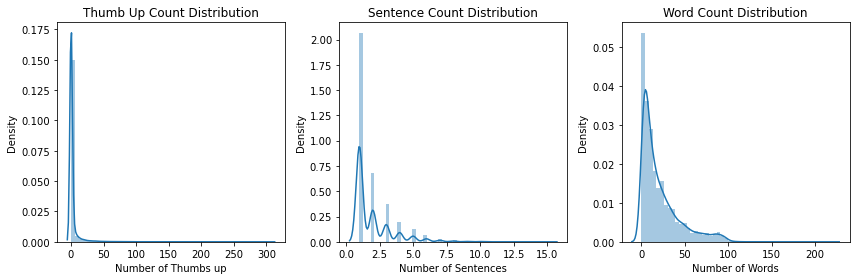

In [20]:
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(app_reviews_df.thumbsUpCount, ax=ax[0])
ax[0].set_title("Thumb Up Count Distribution")
ax[0].set_xlabel("Number of Thumbs up")
sns.distplot(app_reviews_df.sentence_count, ax=ax[1])
ax[1].set_title("Sentence Count Distribution")
ax[1].set_xlabel("Number of Sentences")
sns.distplot(app_reviews_df.word_count, ax=ax[2])
ax[2].set_title("Word Count Distribution")
ax[2].set_xlabel("Number of Words")
plt.tight_layout()
plt.show()

Only abnormality was the comement with 0 words and 1 sentence, turns out is just a period. 

In [21]:
app_reviews_df.loc[app_reviews_df['word_count'] == 0]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,reviews_in_sents,sentence_count,reviews_in_words,word_count
1723,gp:AOqpTOHDuXDtLQF95RQv3a3tvatO2XlzbGbdKK9p74v...,Mii,https://play-lh.googleusercontent.com/a-/AOh14...,.,3,0,1.27.6,2016-05-08 12:21:29,NaN,NaN,newest,com.morrisons.mobile.android,[.],1,[.],0


<ol start="8">
    <li>Count of review per app version.</li>
</ol>

In [22]:
app_reviews_df['ymd'] = [date.split(' ')[0] for date in app_reviews_df['at']]

In [33]:
app_reviews_df['time'] =[date.split(' ')[1] for date in app_reviews_df['at']]

In [47]:
app_reviews_df.loc[app_reviews_df['time'] >'00:00']

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,reviews_in_sents,sentence_count,reviews_in_words,word_count,ymd,time
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,newest,com.tesco.grocery.view,[Found this confusing and difficult],1,"[Found, this, confusing, and, difficult]",5,2022-03-31,16:48:34
1,gp:AOqpTOEALmLSsWoRa5iIEtmENfRtPkvS3O-W7NvitLW...,Alistair Charles,https://play-lh.googleusercontent.com/a/AATXAJ...,Rubbish app. Forgets changes to orders.,1,0,19.29.0,2022-03-30 21:37:56,NaN,NaN,newest,com.tesco.grocery.view,"[Rubbish app., Forgets changes to orders.]",2,"[Rubbish, app, ., Forgets, changes, to, orders...",6,2022-03-30,21:37:56
2,gp:AOqpTOGosMLyacp8xUArioSjY5_628L0xxBJ3BmgTtC...,John Hirst,https://play-lh.googleusercontent.com/a/AATXAJ...,"Rubbish, constantly asking to resign in",1,0,19.29.0,2022-03-30 17:31:00,NaN,NaN,newest,com.tesco.grocery.view,"[Rubbish, constantly asking to resign in]",1,"[Rubbish, ,, constantly, asking, to, resign, in]",6,2022-03-30,17:31:00
3,gp:AOqpTOFAsHuUFqWOKGGtNzL4nKetpiN7Ofa9Bjlg8qw...,Rula Sotiri,https://play-lh.googleusercontent.com/a/AATXAJ...,Terrible,1,0,19.13.0,2022-03-30 10:31:25,NaN,NaN,newest,com.tesco.grocery.view,[Terrible],1,[Terrible],1,2022-03-30,10:31:25
4,gp:AOqpTOGsEOuB5kASf1CwHBp8-DfEzUIjwppVtIJJL9e...,Hey Boo,https://play-lh.googleusercontent.com/a/AATXAJ...,"Got to be a better way to do it, I search for ...",1,0,19.29.0,2022-03-30 08:11:54,NaN,NaN,newest,com.tesco.grocery.view,"[Got to be a better way to do it, I search for...",1,"[Got, to, be, a, better, way, to, do, it, ,, I...",25,2022-03-30,08:11:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8105,gp:AOqpTOH1fwJXRRRnNSzGQUAKzBLRw-c2Yig4IMIxYVT...,Ali kashmiri,https://play-lh.googleusercontent.com/a-/AOh14...,Easy to use .,5,0,2.4.21.2368,2021-06-24 23:30:25,NaN,NaN,newest,com.waitrose.groceries,[Easy to use .],1,"[Easy, to, use, .]",3,2021-06-24,23:30:25
8106,gp:AOqpTOFNE593w6_q2x_6ZgxxztejVdnOxTujR4XA08h...,T Geo,https://play-lh.googleusercontent.com/a-/AOh14...,"Great app, works as needed.",5,0,2.4.21.2368,2021-06-24 22:27:49,NaN,NaN,newest,com.waitrose.groceries,"[Great app, works as needed.]",1,"[Great, app, ,, works, as, needed, .]",5,2021-06-24,22:27:49
8107,gp:AOqpTOFAkddX2Mx8Mfbo0dCCZdvRzVNDS8P2qbh2iMe...,Rebecca Friend,https://play-lh.googleusercontent.com/a/AATXAJ...,Greatest value,5,0,2.4.21.2368,2021-06-24 13:37:38,NaN,NaN,newest,com.waitrose.groceries,[Greatest value],1,"[Greatest, value]",2,2021-06-24,13:37:38
8108,gp:AOqpTOHV-5Dzb3EjKkJd7HMNUt6mmYoAe2aLwVm4pJb...,Samuel Lester,https://play-lh.googleusercontent.com/a/AATXAJ...,My wife and I have been on a mission the past ...,5,17,2.4.21.2368,2021-06-22 21:16:48,NaN,NaN,newest,com.waitrose.groceries,[My wife and I have been on a mission the past...,2,"[My, wife, and, I, have, been, on, a, mission,...",64,2021-06-22,21:16:48


In [23]:
app_reviews_df.loc[app_reviews_df['ymd'] >'2022-03-30']

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,reviews_in_sents,sentence_count,reviews_in_words,word_count,ymd
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,newest,com.tesco.grocery.view,[Found this confusing and difficult],1,"[Found, this, confusing, and, difficult]",5,2022-03-31
600,gp:AOqpTOEbDGZIeQKI9vWsHq7I-EwO42Zz0Ro2Az43zth...,Kerry Martin,https://play-lh.googleusercontent.com/a/AATXAJ...,Search is awful You have to be so specific. Al...,3,0,19.29.0,2022-03-31 18:11:11,NaN,NaN,newest,com.tesco.grocery.view,"[Search is awful You have to be so specific., ...",3,"[Search, is, awful, You, have, to, be, so, spe...",17,2022-03-31
750,gp:AOqpTOFONoo8JA2-MiIO82nMVDSCdPMu5J8cHstjExh...,sharon willems,https://play-lh.googleusercontent.com/a/AATXAJ...,Sometimes doubles my amounts,4,0,19.29.0,2022-03-31 18:49:13,NaN,NaN,newest,com.tesco.grocery.view,[Sometimes doubles my amounts],1,"[Sometimes, doubles, my, amounts]",4,2022-03-31
751,gp:AOqpTOHrfSJbx3zqcT0v2uRaNF1zWtAjfqczHhlSqBB...,John Craddock,https://play-lh.googleusercontent.com/a/AATXAJ...,when shopping from my list of favourites it wo...,4,0,19.29.0,2022-03-31 17:44:47,NaN,NaN,newest,com.tesco.grocery.view,[when shopping from my list of favourites it w...,1,"[when, shopping, from, my, list, of, favourite...",37,2022-03-31
752,gp:AOqpTOE8QJgu_owko_TJoYCSaBf_gGoRM_Ud6r7gUEh...,MasterLector,https://play-lh.googleusercontent.com/a-/AOh14...,Haven't had to change an option and have conta...,4,0,19.29.0,2022-03-31 16:37:57,NaN,NaN,newest,com.tesco.grocery.view,[Haven't had to change an option and have cont...,2,"[Haven't, had, to, change, an, option, and, ha...",31,2022-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7065,gp:AOqpTOHVHyLJT92ZW-wgKtB7sgauJlPksojrFYEr_y8...,Jenny Davies,https://play-lh.googleusercontent.com/a/AATXAJ...,Useless,1,0,2.7.3.2448,2022-03-31 13:41:59,NaN,NaN,newest,com.waitrose.groceries,[Useless],1,[Useless],1,2022-03-31
7066,gp:AOqpTOFOjNlB9foINrakA8n0IZypEALhUNjluf780hN...,Virginia Jones,https://play-lh.googleusercontent.com/a-/AOh14...,Pretty useless as when you get in the store th...,1,0,2.7.3.2448,2022-03-31 07:40:39,NaN,NaN,newest,com.waitrose.groceries,[Pretty useless as when you get in the store t...,1,"[Pretty, useless, as, when, you, get, in, the,...",31,2022-03-31
7480,gp:AOqpTOGhRa6SUYWN7QX2CBDUpG6DXiINokkOtvkx8pw...,cyril Halpenny,https://play-lh.googleusercontent.com/a/AATXAJ...,Confusing and slow to activate on my phone,3,0,2.7.0.2433,2022-03-31 11:37:20,NaN,NaN,newest,com.waitrose.groceries,[Confusing and slow to activate on my phone],1,"[Confusing, and, slow, to, activate, on, my, p...",8,2022-03-31
7860,gp:AOqpTOHNbnxwDfHxAcm5C3wvbgB1C4MhgfZzia8N3ZB...,Jo Jefferis,https://play-lh.googleusercontent.com/a-/AOh14...,Seamless and straightforward to use.,5,0,2.7.3.2448,2022-03-31 17:17:31,NaN,NaN,newest,com.waitrose.groceries,[Seamless and straightforward to use.],1,"[Seamless, and, straightforward, to, use, .]",5,2022-03-31


In [48]:
for app in apps:
    print(app,':', len(app_reviews_df.loc[app_reviews_df['appId'] == app]['reviewCreatedVersion'].value_counts()))

com.tesco.grocery.view : 16
com.morrisons.mobile.android : 89
com.marksandspencer.app : 62
com.asda.android : 74
de.apptiv.business.android.aldi_uk : 73
com.sainsburys.gol : 44
com.waitrose.groceries : 72


The apps seem to be updated very frequently with over 429 versions. Tesco has had 16 versions, morrisons 89, M&S 62, Aldi 73, Sainsburys 74, Waitrose 72.

Number of reviews in the dataset 2022 split by stars

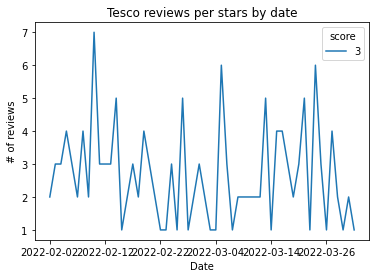

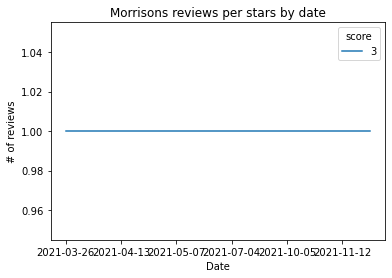

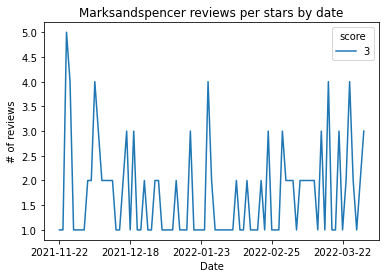

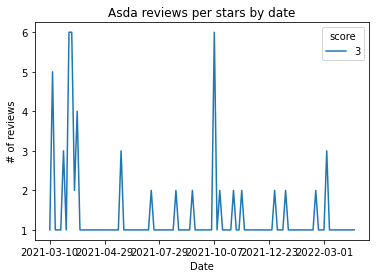

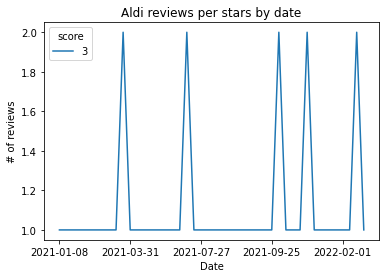

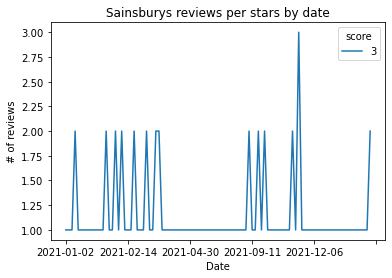

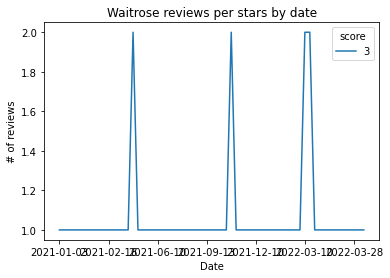

In [25]:
for app in apps:
    name = app.split('.')[1].title() if app != 'de.apptiv.business.android.aldi_uk' else app.split('.')[-1].split('_')[0].title()
    app_reviews_df.loc[(app_reviews_df['score']== 3) & (app_reviews_df['ymd']>'2021-01-01') & (app_reviews_df['appId'] == app) ].groupby(['ymd','score'])['score'].count().unstack().plot(legend=True)
    plt.title(f'{name} reviews per stars by date')
    plt.xlabel('Date')
    plt.ylabel('# of reviews')
    plt.show()
    

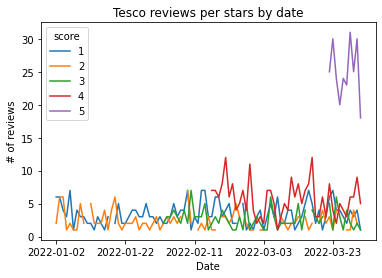

In [193]:
app_reviews_df.loc[(app_reviews_df['ymd']>'2022-01-01') & (app_reviews_df['appId'] == 'com.tesco.grocery.view') ].groupby(['ymd','score'])['score'].count().unstack().plot(legend=True)
plt.title('Tesco reviews per stars by date')
plt.xlabel('Date')
plt.ylabel('# of reviews')
plt.show()

### Make Sentiment Analysis

Make label of pos, neg, neutral based on score

In [126]:
scores = []
for score in app_reviews_df['score']:
    if score < 3:
        scores.append('neg')
    elif score > 3:
        scores.append('pos')
    else:
        scores.append('neu')
        
app_reviews_df['label'] = scores

In [131]:
app_reviews_df['label'].value_counts()

neg    3814
pos    3336
neu     960
Name: label, dtype: int64

In [50]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,reviews_in_sents,sentence_count,reviews_in_words,word_count,ymd,time
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,newest,com.tesco.grocery.view,[Found this confusing and difficult],1,"[Found, this, confusing, and, difficult]",5,2022-03-31,16:48:34
1,gp:AOqpTOEALmLSsWoRa5iIEtmENfRtPkvS3O-W7NvitLW...,Alistair Charles,https://play-lh.googleusercontent.com/a/AATXAJ...,Rubbish app. Forgets changes to orders.,1,0,19.29.0,2022-03-30 21:37:56,NaN,NaN,newest,com.tesco.grocery.view,"[Rubbish app., Forgets changes to orders.]",2,"[Rubbish, app, ., Forgets, changes, to, orders...",6,2022-03-30,21:37:56
2,gp:AOqpTOGosMLyacp8xUArioSjY5_628L0xxBJ3BmgTtC...,John Hirst,https://play-lh.googleusercontent.com/a/AATXAJ...,"Rubbish, constantly asking to resign in",1,0,19.29.0,2022-03-30 17:31:00,NaN,NaN,newest,com.tesco.grocery.view,"[Rubbish, constantly asking to resign in]",1,"[Rubbish, ,, constantly, asking, to, resign, in]",6,2022-03-30,17:31:00
3,gp:AOqpTOFAsHuUFqWOKGGtNzL4nKetpiN7Ofa9Bjlg8qw...,Rula Sotiri,https://play-lh.googleusercontent.com/a/AATXAJ...,Terrible,1,0,19.13.0,2022-03-30 10:31:25,NaN,NaN,newest,com.tesco.grocery.view,[Terrible],1,[Terrible],1,2022-03-30,10:31:25
4,gp:AOqpTOGsEOuB5kASf1CwHBp8-DfEzUIjwppVtIJJL9e...,Hey Boo,https://play-lh.googleusercontent.com/a/AATXAJ...,"Got to be a better way to do it, I search for ...",1,0,19.29.0,2022-03-30 08:11:54,NaN,NaN,newest,com.tesco.grocery.view,"[Got to be a better way to do it, I search for...",1,"[Got, to, be, a, better, way, to, do, it, ,, I...",25,2022-03-30,08:11:54


In [455]:
def get_specific_speech(comments, pos): 
    all_words = []
    i = 0
    for review in comments:
        all_words.append(remove_stopwords(review))
        i += 1    
    words = []
    for review in all_words:
        for word, pos_code in nltk.pos_tag(review):
            pos_to_add = []
            if pos_code in pos:
                pos_to_add.append(word)
        words.append(pos_to_add)
        
    return words 

def remove_stopwords(toks_words, type_of_gram = 'none'):
    if type_of_gram =='bi':
        stopwords = ['to', 'the', 'have', 'on', 'in', 'is', 'this', 'and', 'i',
                 'you', 'of', 'be', 'for', 'my', 'that', 'a', 'very', 'there']
    elif type_of_gram == 'tri':
        stopwords = ['and', 'to', 'the']
    else:
        stopwords = ['..', ',']
    remove_these = set(stopwords + list(string.punctuation) + list(string.digits))
    filtered_text = [word for word in toks_words if not word in remove_these]
    return filtered_text

def make_dist_plot(column, number_of_words):
    flat_list = [item for sublist in column for item in sublist]
    fdist = FreqDist(flat_list)
    return fdist.plot(number_of_words,title=f'Frequency distribution for {number_of_words} most common tokens in our collection.')

Make review_in_words lowercase

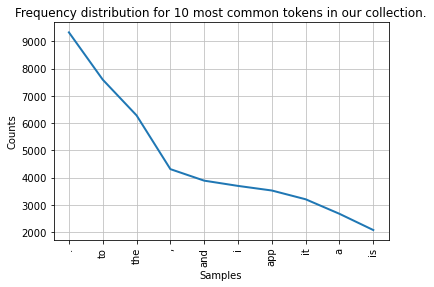

<AxesSubplot:title={'center':'Frequency distribution for 10 most common tokens in our collection.'}, xlabel='Samples', ylabel='Counts'>

In [117]:
make_dist_plot(app_reviews_df['reviews_in_words'], 10)

In [98]:
all_words = []
for review in app_reviews_df['reviews_in_words']:
    review_lower = []
    for word in review:
        review_lower.append(word.lower())
    all_words.append(review_lower)
    
app_reviews_df['reviews_in_words'] = all_words

Make label using VADER

In [177]:
def classifySentenceVADER(reviews_in_sens):
    sid = SIA()
    labels = []
    for review in reviews_in_sens:
        overall_score = 0
        for sentence in review:
            ss = sid.polarity_scores(sentence)
            overall_score += ss['compound'] 
        if overall_score == 0.0:
            labels.append('neu')
        elif overall_score > 0:
            labels.append('pos')
        elif overall_score < 0 :
            labels.append('neg')
    return labels

In [178]:
app_reviews_df['vader_label'] = classifySentenceVADER(app_reviews_df['reviews_in_sents'])

In [186]:
app_reviews_df.loc[app_reviews_df['label'] != app_reviews_df['vader_label']]['vader_label'].value_counts()

pos    1363
neu    1243
neg     551
Name: vader_label, dtype: int64

We can see that the VADER classifier is not the best, whilst it does classify properly x number of reviews. It has clear discrepancies with those set with the heurisitc of >3 positive <3 negative and 3 stars neutral. With there being 1243 reviews it classifies as neutral which are not neutral in terms of stars, a closer look sees that the classifier in multiple case is unable to determine the sentiment so gives it a score of 0.0 i.e. neutral.

Using TextBlob to check performance and compare VADER

In [191]:
from textblob import TextBlob
pol = lambda x: TextBlob(x).sentiment.polarity

app_reviews_df['textblob_label'] = app_reviews_df['content'].apply(pol)
app_reviews_df['textblob_label'] = ['pos' if label > 0 else 'neg' if label < 0 else 'neu' for label in app_reviews_df['textblob_label']]
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,...,appId,reviews_in_sents,sentence_count,reviews_in_words,word_count,ymd,time,label,vader_label,textblob_label
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,...,com.tesco.grocery.view,[Found this confusing and difficult],1,"[found, this, confusing, and, difficult]",5,2022-03-31,16:48:34,neg,neg,neg
1,gp:AOqpTOEALmLSsWoRa5iIEtmENfRtPkvS3O-W7NvitLW...,Alistair Charles,https://play-lh.googleusercontent.com/a/AATXAJ...,Rubbish app. Forgets changes to orders.,1,0,19.29.0,2022-03-30 21:37:56,NaN,NaN,...,com.tesco.grocery.view,"[Rubbish app., Forgets changes to orders.]",2,"[rubbish, app, ., forgets, changes, to, orders...",6,2022-03-30,21:37:56,neg,neu,neu
2,gp:AOqpTOGosMLyacp8xUArioSjY5_628L0xxBJ3BmgTtC...,John Hirst,https://play-lh.googleusercontent.com/a/AATXAJ...,"Rubbish, constantly asking to resign in",1,0,19.29.0,2022-03-30 17:31:00,NaN,NaN,...,com.tesco.grocery.view,"[Rubbish, constantly asking to resign in]",1,"[rubbish, ,, constantly, asking, to, resign, in]",6,2022-03-30,17:31:00,neg,neg,neu
3,gp:AOqpTOFAsHuUFqWOKGGtNzL4nKetpiN7Ofa9Bjlg8qw...,Rula Sotiri,https://play-lh.googleusercontent.com/a/AATXAJ...,Terrible,1,0,19.13.0,2022-03-30 10:31:25,NaN,NaN,...,com.tesco.grocery.view,[Terrible],1,[terrible],1,2022-03-30,10:31:25,neg,neg,neg
4,gp:AOqpTOGsEOuB5kASf1CwHBp8-DfEzUIjwppVtIJJL9e...,Hey Boo,https://play-lh.googleusercontent.com/a/AATXAJ...,"Got to be a better way to do it, I search for ...",1,0,19.29.0,2022-03-30 08:11:54,NaN,NaN,...,com.tesco.grocery.view,"[Got to be a better way to do it, I search for...",1,"[got, to, be, a, better, way, to, do, it, ,, i...",25,2022-03-30,08:11:54,neg,pos,pos


Using HuggingFace BERT Base model to check performance and compare VADER and TextBlob

In [203]:
specific_model = pipeline(model="nlptown/bert-base-multilingual-uncased-sentiment")
specific_model(data)

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

[{'label': '1 star', 'score': 0.576156735420227},
 {'label': '1 star', 'score': 0.6346078515052795}]

In [223]:
bert_score = []
for review in app_reviews_df['content']:
    star = specific_model(review)[0]['label'].split(' ')[0]
    bert_score.append(star)

In [226]:
app_reviews_df['bert_score'] = bert_score

In [229]:
scores = []
for score in app_reviews_df['bert_score']:
    if int(score) < 3:
        scores.append('neg')
    elif int(score) > 3:
        scores.append('pos')
    else:
        scores.append('neu')
        
app_reviews_df['bert_label'] = scores

Significant improvement in using BERT to classify the reviews, nearly cuts the mislabeling between pos/neg/neutral by half. Served as a training for use of future unsupervised problems.

In [255]:
app_reviews_df.loc[app_reviews_df['replyContent'].notna()]['replyContent']

346     Hi Jane. Thanks for your feedback. It sounds l...
651     Hi there. Could you please email us at appsfee...
765     Hi, thanks for your feedback, it really helped...
955     Hi Marie. Thanks for your feedback. We're real...
1766    Hello, we have temporarily turned off the app ...
                              ...                        
7613    Hi Nick Hall, there was an issue that meant so...
7616    Hi Phil, it seems that you were on an old vers...
7666    Hi Narney Roby - We fixed some defects in a re...
7822    Hi Gillian, we recently made some significant ...
7832    Hi, this was a temporary issue which was resol...
Name: replyContent, Length: 147, dtype: object

Checkpoint

In [550]:
app_reviews_df.to_csv('src/reviews_1.csv', index=None, header=True)

Extract topics from the reviews

In [301]:
get_specific_speech(app_reviews_df['reviews_in_words'], ['NN'])

[[],
 [],
 [],
 [],
 [],
 ['plan'],
 [],
 [],
 ['service'],
 [],
 ['visa'],
 [],
 [],
 ['phone'],
 ['job'],
 ['system'],
 ['etc'],
 ['scam'],
 [],
 ['work'],
 [],
 ['baskett'],
 [],
 [],
 ['address'],
 [],
 ['nightmare'],
 ['site'],
 ['tesco'],
 ['screen'],
 ['work'],
 ['delivery'],
 ['service'],
 ['avoid'],
 ['app'],
 ['order'],
 [],
 ['order'],
 ['change'],
 [],
 [],
 [],
 ['business'],
 ['payment'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['avoid'],
 ['neighbour'],
 [],
 [],
 [],
 [],
 ['card'],
 [],
 ['help'],
 [],
 [],
 ['frictionless'],
 [],
 ['property'],
 ['rwag'],
 [],
 [],
 [],
 ['app'],
 ['experience'],
 [],
 [],
 [],
 [],
 ['security'],
 [],
 [],
 ['suppler'],
 [],
 ['ssupermarket'],
 ['integration'],
 ['app'],
 ['change'],
 [],
 [],
 [],
 [],
 ['supermarket'],
 [],
 ['tescos'],
 ['rubbish'],
 [],
 [],
 ['#boycottesco'],
 [],
 [],
 ['coupon'],
 [],
 ['service'],
 [],
 [],
 ['simple'],
 [],
 [],
 [],
 [],
 [],
 ['practice'],
 [],
 ['delivering'],
 [],
 [],
 ['list'],
 ["did

Normalise the words checkout, are not, club card, no longer

In [299]:
for review in app_reviews_df['reviews_in_words']:
    for index, word in enumerate(review):
        if (index+1 < len(review) and index - 1 >= 0):
            prev_el = str(review[index-1])
            curr_el = str(word)
            next_el = str(review[index+1])
            #print(prev_el, curr_el, next_el)
            if (prev_el == 'check' and curr_el == 'out') or (prev_el == 'club' and curr_el == 'card'):
                review[index-1:index] = [''.join(review[index-1:index])]
            elif (curr_el == 'check' and next_el == 'out') or (curr_el == 'club' and next_el == 'card'):
                review[index:index+2] = [''.join(review[index:index+2])]

Lemmaatization

In [303]:
ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
POS_LIST = [NOUN, VERB, ADJ, ADV]

In [320]:
lemmatizer = WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    print(nltk_tagged)
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

print(lemmatize_sentence("I am voting for that politician in this NLTK Lemmatization example sentence"))

[('I', 'PRP'), ('am', 'VBP'), ('voting', 'VBG'), ('for', 'IN'), ('that', 'DT'), ('politician', 'NN'), ('in', 'IN'), ('this', 'DT'), ('NLTK', 'NNP'), ('Lemmatization', 'NNP'), ('example', 'NN'), ('sentence', 'NN')]
['I', 'be', 'vote', 'for', 'that', 'politician', 'in', 'this', 'NLTK', 'Lemmatization', 'example', 'sentence']


In [326]:
lemmatized_sentence = []
for review in app_reviews_df['reviews_in_words']:
    nltk_tagged = nltk.pos_tag(review)
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    review_lem = []
    #print(wordnet_tagged)
    for word, tag in wordnet_tagged:
        if tag is None:
            review_lem.append(word)
        else:        
            review_lem.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence.append(review_lem)
    
app_reviews_df['reviews_lemmatized'] = lemmatized_sentence

In [345]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,...,reviews_in_words,word_count,ymd,time,label,vader_label,textblob_label,bert_score,bert_label,reviews_lemmatized
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,...,"[found, this, confusing, and, difficult]",5,2022-03-31,16:48:34,neg,neg,neg,2,neg,"[find, this, confusing, and, difficult]"
1,gp:AOqpTOEALmLSsWoRa5iIEtmENfRtPkvS3O-W7NvitLW...,Alistair Charles,https://play-lh.googleusercontent.com/a/AATXAJ...,Rubbish app. Forgets changes to orders.,1,0,19.29.0,2022-03-30 21:37:56,NaN,NaN,...,"[rubbish, app, ., forgets, changes, to, orders...",6,2022-03-30,21:37:56,neg,neu,neu,1,neg,"[rubbish, app, ., forgets, change, to, order, .]"
2,gp:AOqpTOGosMLyacp8xUArioSjY5_628L0xxBJ3BmgTtC...,John Hirst,https://play-lh.googleusercontent.com/a/AATXAJ...,"Rubbish, constantly asking to resign in",1,0,19.29.0,2022-03-30 17:31:00,NaN,NaN,...,"[rubbish, ,, constantly, asking, to, resign, in]",6,2022-03-30,17:31:00,neg,neg,neu,1,neg,"[rubbish, ,, constantly, ask, to, resign, in]"
3,gp:AOqpTOFAsHuUFqWOKGGtNzL4nKetpiN7Ofa9Bjlg8qw...,Rula Sotiri,https://play-lh.googleusercontent.com/a/AATXAJ...,Terrible,1,0,19.13.0,2022-03-30 10:31:25,NaN,NaN,...,[terrible],1,2022-03-30,10:31:25,neg,neg,neg,1,neg,[terrible]
4,gp:AOqpTOGsEOuB5kASf1CwHBp8-DfEzUIjwppVtIJJL9e...,Hey Boo,https://play-lh.googleusercontent.com/a/AATXAJ...,"Got to be a better way to do it, I search for ...",1,0,19.29.0,2022-03-30 08:11:54,NaN,NaN,...,"[got, to, be, a, better, way, to, do, it, ,, i...",25,2022-03-30,08:11:54,neg,pos,pos,2,neg,"[get, to, be, a, good, way, to, do, it, ,, i, ..."


Words that are nouns

In [456]:
get_specific_speech(app_reviews_df['reviews_lemmatized'], ['NN'])

[[], ['order'], [], [], [], ['plan'], ['instock'], [], ['service'], [], ['visa'], [], [], ['phone'], ['job'], ['system'], ['etc'], ['scam'], [], ['work'], [], ['baskett'], [], ['order'], ['address'], [], ['nightmare'], ['site'], ['tesco'], ['screen'], ['work'], ['delivery'], ['service'], ['avoid'], ['app'], ['order'], [], ['order'], ['change'], [], [], [], ['business'], ['payment'], [], ['irritate'], [], [], [], ['glitch'], [], [], ['avoid'], ['neighbour'], [], [], [], ['track'], ['card'], ['star'], ['help'], [], [], ['frictionless'], [], ['property'], ['rwag'], [], [], [], ['app'], ['experience'], ['target'], [], ['order'], ['list'], ['security'], [], [], ['suppler'], ['product'], ['ssupermarket'], ['integration'], ['app'], ['change'], [], [], ['address'], [], ['supermarket'], [], ['tescos'], ['rubbish'], ['annoy'], [], ['#boycottesco'], ['price'], [], ['coupon'], ['basket'], ['service'], [], [], ['simple'], [], [], [], [], [], ['practice'], ['order'], ['delivering'], [], [], ['list']

### Split df by company

In [357]:
def split_df(df, column, value):
    new_df = df[df[column] == value]
    return new_df

def split_per_app(df, column_with_names):
    all_dfs = [] 
    apps = df[column_with_names].unique()
    for app in apps:
        name = split_df(df, column_with_names, app)
        all_dfs.append(name)  
    return all_dfs

In [358]:
split_reviews = split_per_app(app_reviews_df, 'appId')

tesco_reviews = split_reviews[0]
morrisons_reviews = split_reviews[1]
marksandspencer_reviews = split_reviews[2]
asda_reviews = split_reviews[3]
aldi_reviews = split_reviews[4]
sainsburys_reviews = split_reviews[5]
waitrose_reviews = split_reviews[6]

In [433]:
morrisons_reviews.reset_index(inplace = True, drop = True)
marksandspencer_reviews.reset_index(inplace = True, drop = True)
asda_reviews.reset_index(inplace = True, drop = True)
aldi_reviews.reset_index(inplace = True, drop = True)
sainsburys_reviews.reset_index(inplace = True, drop = True)
waitrose_reviews.reset_index(inplace = True, drop = True)

Distribution of words

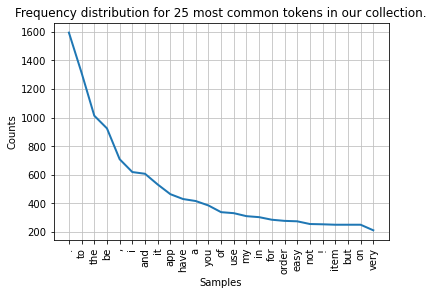

<AxesSubplot:title={'center':'Frequency distribution for 25 most common tokens in our collection.'}, xlabel='Samples', ylabel='Counts'>

In [366]:
make_dist_plot(tesco_reviews['reviews_lemmatized'], 25)

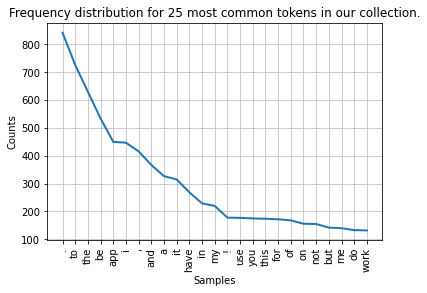

<AxesSubplot:title={'center':'Frequency distribution for 25 most common tokens in our collection.'}, xlabel='Samples', ylabel='Counts'>

In [367]:
make_dist_plot(morrisons_reviews['reviews_lemmatized'], 25)

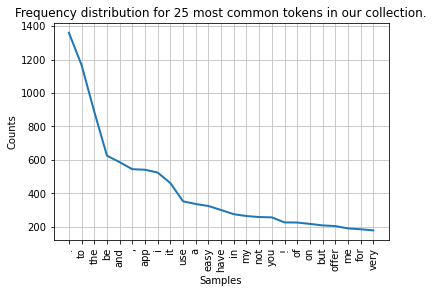

<AxesSubplot:title={'center':'Frequency distribution for 25 most common tokens in our collection.'}, xlabel='Samples', ylabel='Counts'>

In [368]:
make_dist_plot(marksandspencer_reviews['reviews_lemmatized'], 25)

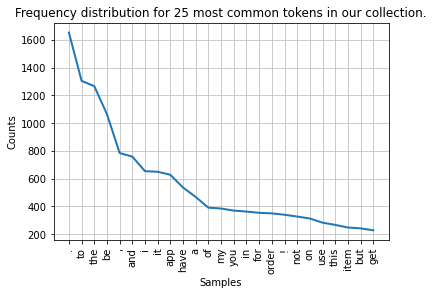

<AxesSubplot:title={'center':'Frequency distribution for 25 most common tokens in our collection.'}, xlabel='Samples', ylabel='Counts'>

In [369]:
make_dist_plot(asda_reviews['reviews_lemmatized'], 25)

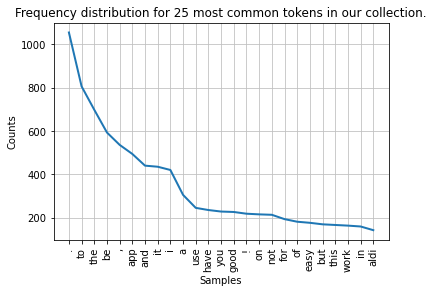

<AxesSubplot:title={'center':'Frequency distribution for 25 most common tokens in our collection.'}, xlabel='Samples', ylabel='Counts'>

In [370]:
make_dist_plot(aldi_reviews['reviews_lemmatized'], 25)

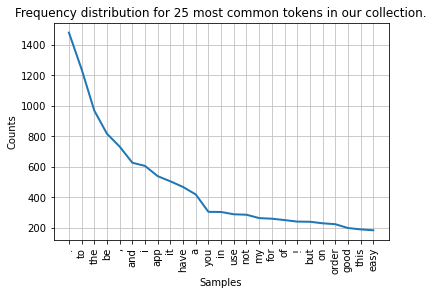

<AxesSubplot:title={'center':'Frequency distribution for 25 most common tokens in our collection.'}, xlabel='Samples', ylabel='Counts'>

In [371]:
make_dist_plot(sainsburys_reviews['reviews_lemmatized'], 25)

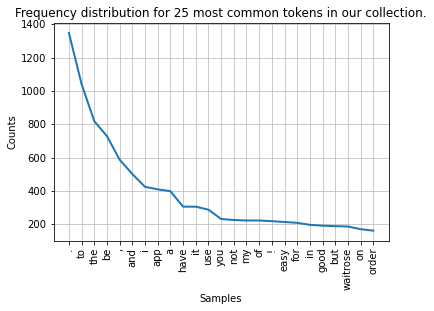

<AxesSubplot:title={'center':'Frequency distribution for 25 most common tokens in our collection.'}, xlabel='Samples', ylabel='Counts'>

In [372]:
make_dist_plot(waitrose_reviews['reviews_lemmatized'], 25)

Bigrams and trigram

In [492]:
from nltk import ngrams

def get_ngram(lemma_column, number_of_words, n):
    if type(lemma_column[0]) is not str:
        flat_list = [item for sublist in lemma_column for item in sublist]
    else:
        flat_list = lemma_column
    ngram = [b for b in ngrams(flat_list, n)]
    freq_ngrams = nltk.FreqDist(ngram)
    #print(freq_ngrams.most_common(number_of_words)) 
    #fdist = FreqDist(freq_ngrams)
    #fdist.plot(number_of_words,title=f'Frequency distribution for {number_of_words} most common tokens in our collection.')
    return ngram

In [857]:
def remove_stopwords_2(lemma_column, type_of_gram):
    flat_list = [item for sublist in lemma_column for item in sublist]
    if type_of_gram =='bi':
        new_stopwords = ['to', 'the', 'have', 'on', 'in', 'is', 'this', 'and', 'i',
                 'you', 'of', 'be', 'for', 'my', 'that', 'a', 'very', 'there', '...', '..', ',', 'do', 'not',
                        'it', "doesn't", 'let', 'me', 'every', 'longer', 'even', 'though', 'too', 'an', 'use',
                        'rather', 'through', 'your', 'more', 'now', 'keep', 'but', 'at','all',"can't", 'with',
                        "won't",'when', 'sort', 'please', 'need', 'app', 'easy', 'quick']
    elif type_of_gram == 'tri':
        new_stopwords = ['and', 'to', 'the', 'i', 'you', 'this', 'a', 'me', 'be', 'very', 'it', '...', '..', ',',
                        'for','of', 'easy', 'quick']
    else:
        new_stopwords = ['..', ',', '...']
    remove_these = set(new_stopwords + list(string.punctuation) + list(string.digits))# + stopwords.words('english'))
    filtered_text = [word for word in flat_list if not word in remove_these]
    return filtered_text

In [569]:
def ngram_by_label(df, stopwords, number_of_grams, n_grams,  label, color):
    pos_df = df.loc[df['label'] == label]
    ngrams = get_ngram(remove_stopwords_2(pos_df['reviews_lemmatized'], stopwords), number_of_grams, n_grams)
    ngrams_series = pd.Series(ngrams).value_counts()[:number_of_grams]
    plt.title(f'{number_of_grams} Most Frequently Occuring {stopwords}grams')
    plt.ylabel(f'{stopwords}gram')
    plt.xlabel('# of Occurances')
    ngrams_series.sort_values().plot.barh(color=color, width=.9, figsize=(12, 8))

In [829]:
tesco_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,...,time,label,vader_label,textblob_label,bert_score,bert_label,reviews_lemmatized,year,month,day
0,gp:AOqpTOHoLYWCleX8HM-fJST-nS6_Q7nRCKgUfcXviZW...,Joyce Jamieson,https://play-lh.googleusercontent.com/a/AATXAJ...,Found this confusing and difficult,1,0,19.29.0,2022-03-31 16:48:34,NaN,NaN,...,16:48:34,neg,neg,neg,2,neg,"[find, this, confusing, and, difficult]",2022,3,31
1,gp:AOqpTOEALmLSsWoRa5iIEtmENfRtPkvS3O-W7NvitLW...,Alistair Charles,https://play-lh.googleusercontent.com/a/AATXAJ...,Rubbish app. Forgets changes to orders.,1,0,19.29.0,2022-03-30 21:37:56,NaN,NaN,...,21:37:56,neg,neu,neu,1,neg,"[rubbish, app, ., forgets, change, to, order, .]",2022,3,30
2,gp:AOqpTOGosMLyacp8xUArioSjY5_628L0xxBJ3BmgTtC...,John Hirst,https://play-lh.googleusercontent.com/a/AATXAJ...,"Rubbish, constantly asking to resign in",1,0,19.29.0,2022-03-30 17:31:00,NaN,NaN,...,17:31:00,neg,neg,neu,1,neg,"[rubbish, ,, constantly, ask, to, resign, in]",2022,3,30
3,gp:AOqpTOFAsHuUFqWOKGGtNzL4nKetpiN7Ofa9Bjlg8qw...,Rula Sotiri,https://play-lh.googleusercontent.com/a/AATXAJ...,Terrible,1,0,19.13.0,2022-03-30 10:31:25,NaN,NaN,...,10:31:25,neg,neg,neg,1,neg,[terrible],2022,3,30
4,gp:AOqpTOGsEOuB5kASf1CwHBp8-DfEzUIjwppVtIJJL9e...,Hey Boo,https://play-lh.googleusercontent.com/a/AATXAJ...,"Got to be a better way to do it, I search for ...",1,0,19.29.0,2022-03-30 08:11:54,NaN,NaN,...,08:11:54,neg,pos,pos,2,neg,"[get, to, be, a, good, way, to, do, it, ,, i, ...",2022,3,30


## Tesco's bi/trigrams

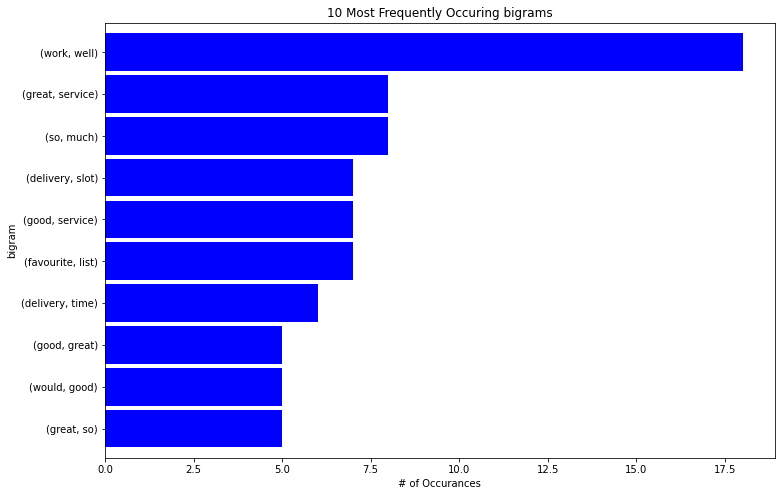

In [858]:
ngram_by_label(tesco_reviews, 'bi', 10, 2, 'pos', 'blue')

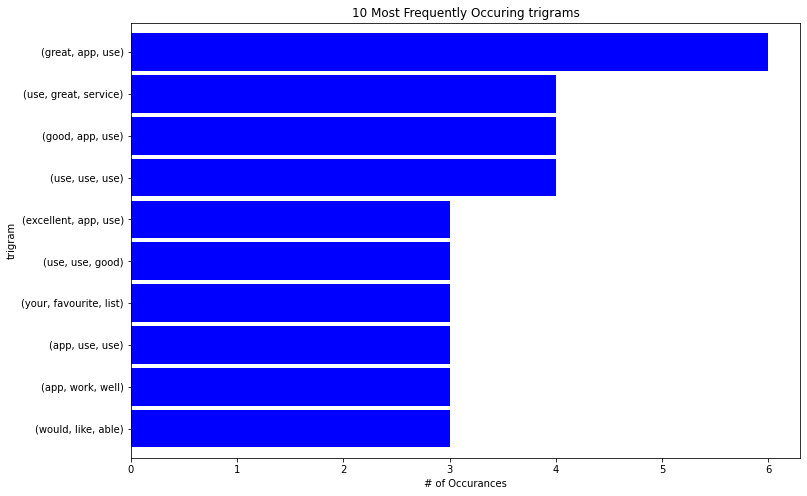

In [859]:
ngram_by_label(tesco_reviews, 'tri', 10, 3, 'pos', 'blue')

## Morrison's bi/trigrams

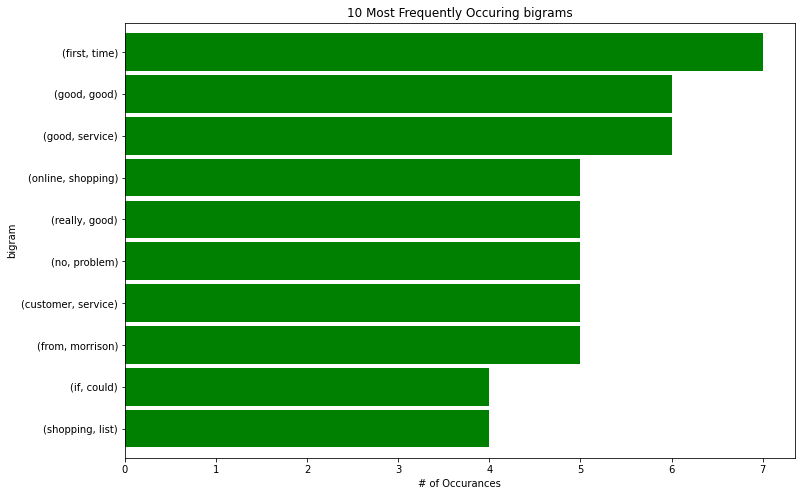

In [860]:
ngram_by_label(morrisons_reviews, 'bi', 10, 2, 'pos', 'green')

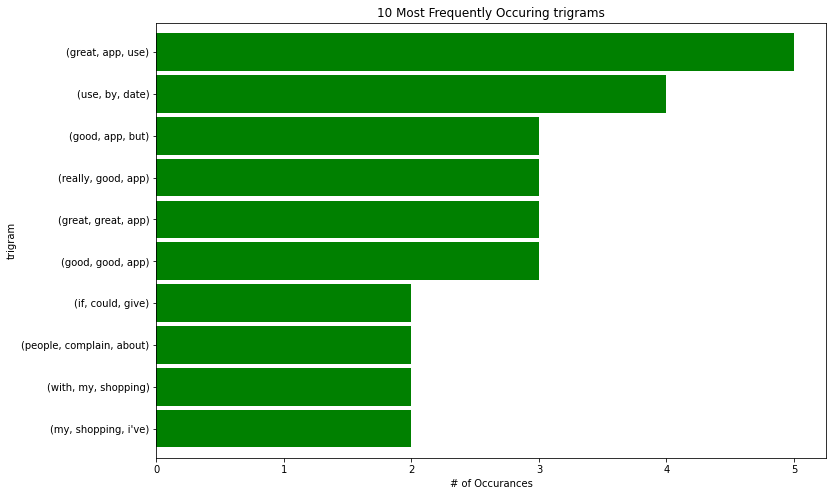

In [861]:
ngram_by_label(morrisons_reviews, 'tri', 10, 3, 'pos', 'green')

## M&S's bi/trigrams

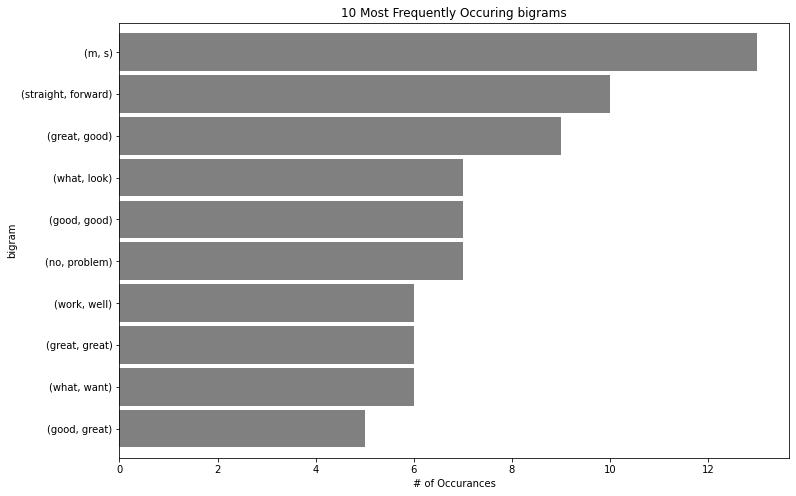

In [862]:
ngram_by_label(marksandspencer_reviews, 'bi', 10, 2, 'pos', 'grey')

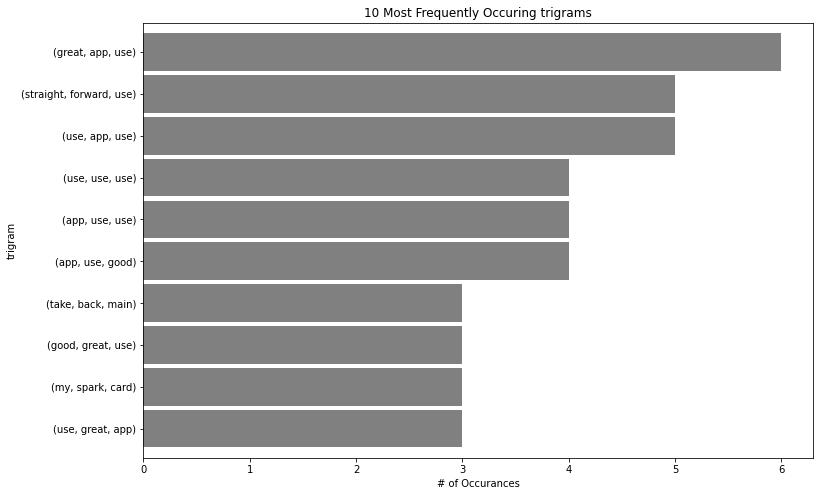

In [863]:
ngram_by_label(marksandspencer_reviews, 'tri', 10, 3, 'pos', 'grey')

## Asda's bi/trigrams

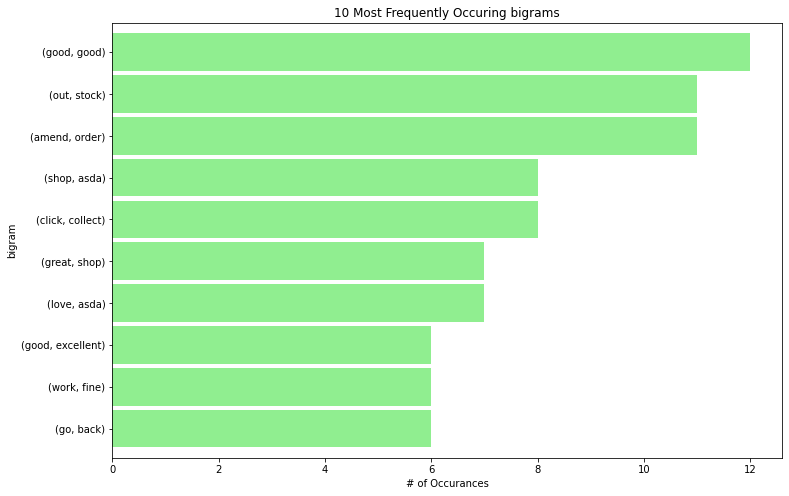

In [864]:
ngram_by_label(asda_reviews, 'bi', 10, 2, 'pos', 'lightgreen')

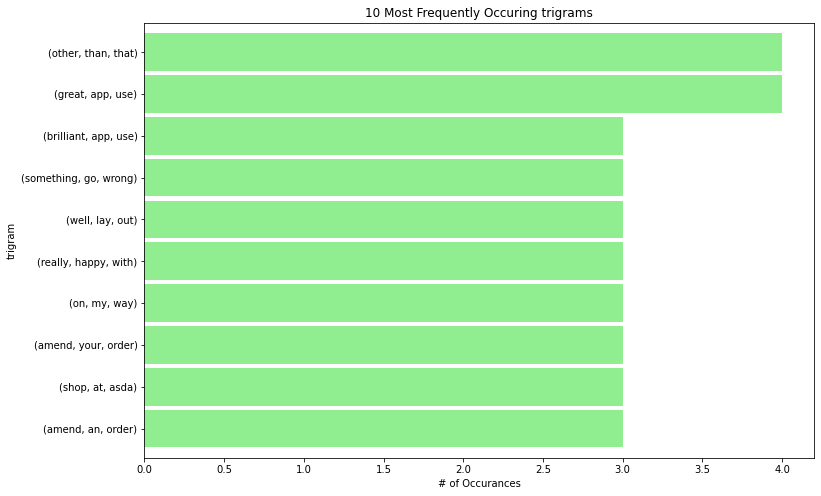

In [865]:
ngram_by_label(asda_reviews, 'tri', 10, 3, 'pos', 'lightgreen')

## ALDI's bi/trigrams

/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0, flags=flags)


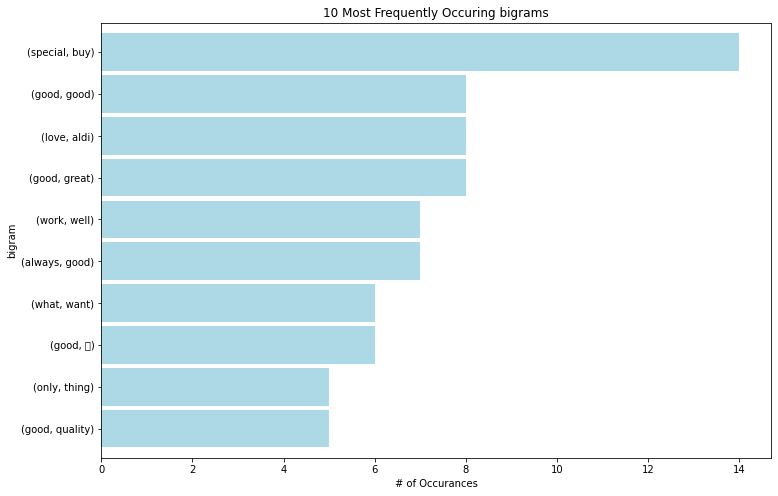

In [866]:
ngram_by_label(aldi_reviews, 'bi', 10, 2, 'pos', 'lightblue')

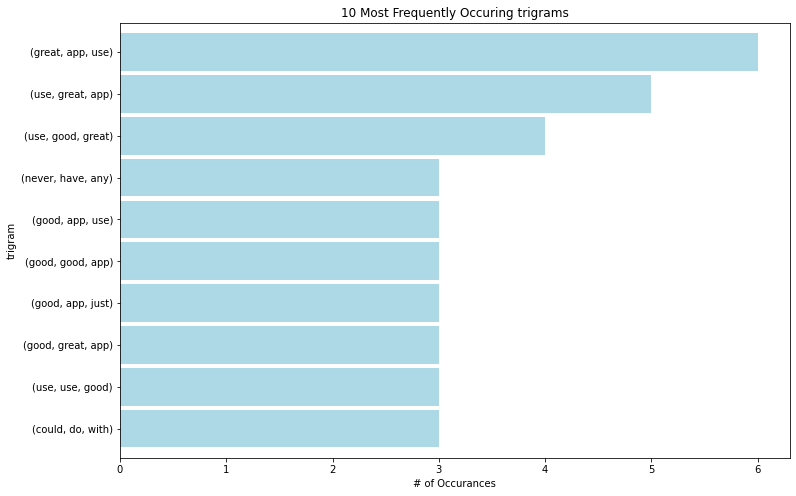

In [867]:
ngram_by_label(aldi_reviews, 'tri', 10, 3, 'pos', 'lightblue')

## Sainsbury's bi/trigrams

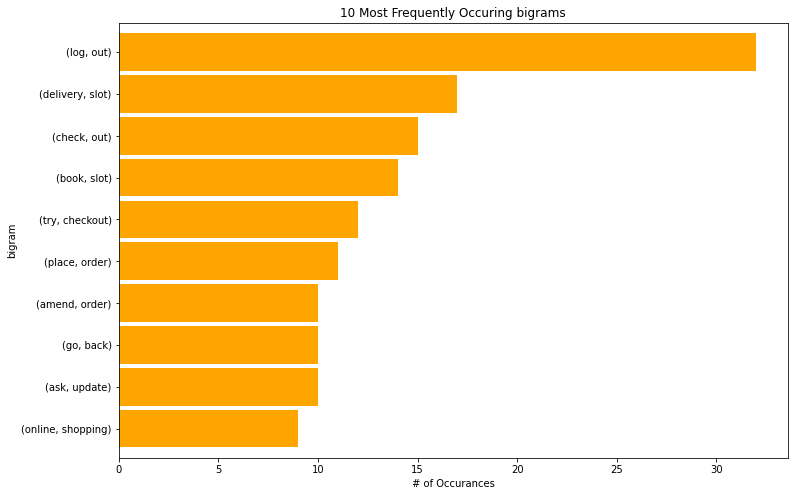

In [823]:
ngram_by_label(sainsburys_reviews, 'bi', 10, 2, 'neg', 'orange')

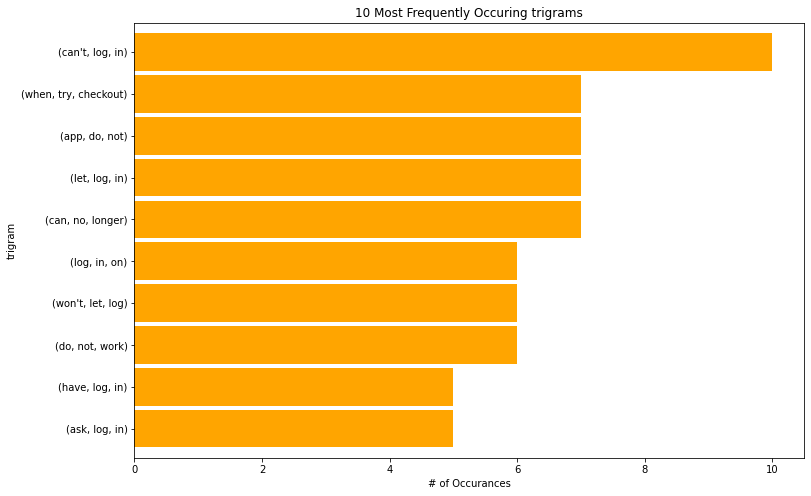

In [826]:
ngram_by_label(sainsburys_reviews, 'tri', 10, 3, 'neg', 'orange')

## Waitrose's bi/trigrams

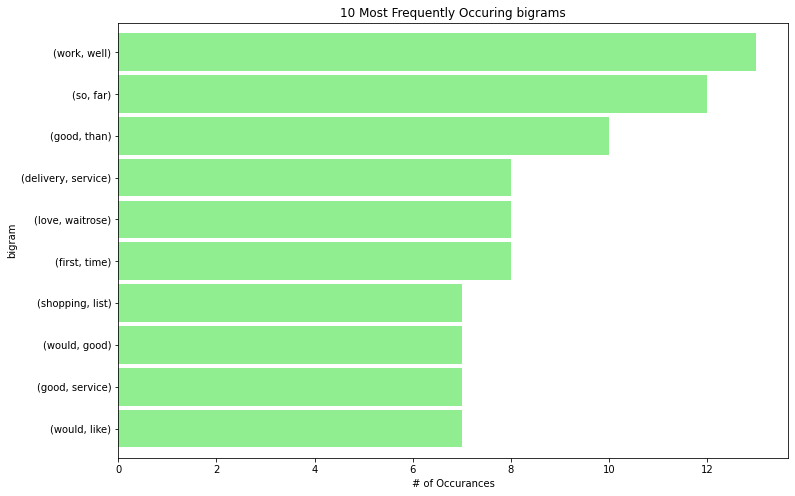

In [886]:
ngram_by_label(waitrose_reviews, 'bi', 10, 2, 'pos', 'lightgreen')

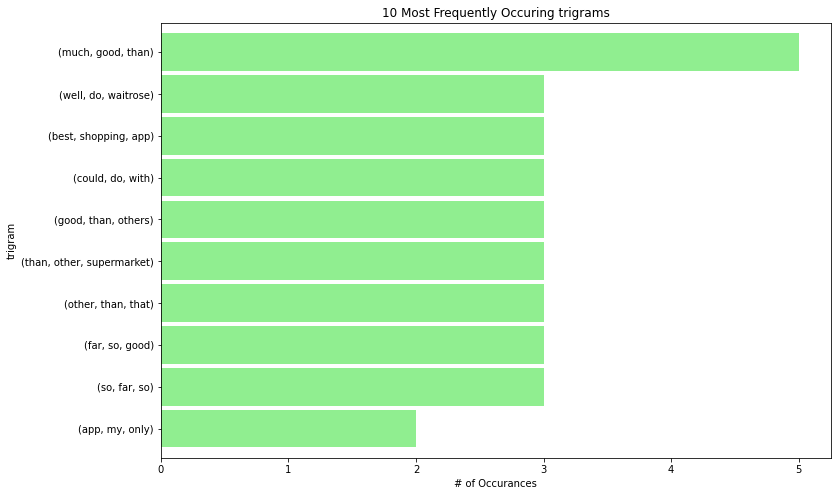

In [887]:
ngram_by_label(waitrose_reviews, 'tri', 10, 3, 'pos', 'lightgreen')

In [551]:
tesco_reviews.to_csv('src/tesco_reviews.csv', index=None, header=True)
morrisons_reviews.to_csv('src/morrisons_reviews.csv', index=None, header=True)
marksandspencer_reviews.to_csv('src/marksandspencer_reviews.csv', index=None, header=True)
asda_reviews.to_csv('src/asda_reviews.csv', index=None, header=True)
aldi_reviews.to_csv('src/aldi_reviews.csv', index=None, header=True)
sainsburys_reviews.to_csv('src/sainsburys_reviews.csv', index=None, header=True)
waitrose_reviews.to_csv('src/waitrose_reviews.csv', index=None, header=True)

### Get wordcloud of adjectives

In [885]:
from collections import Counter
get_specific_speech(sainsburys_reviews['reviews_lemmatized'], ['JJ', 'JJR', 'JJS', 'VB'])

[[], [], [], ['more'], [], [], [], [], ['checkout'], ['helpful'], [], [], [], ['buy'], [], [], [], [], [], ['online'], [], ["asda's"], ['open'], [], ['annoy'], [], ['unusable'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['further'], [], [], ['same'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['open'], [], [], ['work'], [], [], [], [], [], [], ['blank'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['login'], ['do'], ['use'], [], [], [], [], [], [], [], [], [], [], [], ['login'], [], [], ['same'], [], [], [], [], [], ['slow'], [], ['buggy'], [], [], [], ['register'], [], [], [], ['connect'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['cumbersome'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['ocado'], [], [], ['update'], ['be'], ['sort'], [], ['good'], [], [], [], [], [], [], [], [], [], [], [], [], 

### Split date to year/month/day

In [639]:
year = []
month = []
day = []
for date in tesco_reviews['ymd']:
    year.append(int(date.split('-')[0]))
    month.append(int(date.split('-')[1]))
    day.append(int(date.split('-')[2]))
    
tesco_reviews['year'] = year
tesco_reviews['month'] = month
tesco_reviews['day'] = day

year = []
month = []
day = []
for date in sainsburys_reviews['ymd']:
    year.append(int(date.split('-')[0]))
    month.append(int(date.split('-')[1]))
    day.append(int(date.split('-')[2]))
    
sainsburys_reviews['year'] = year
sainsburys_reviews['month'] = month
sainsburys_reviews['day'] = day

/var/folders/jq/96z3l_5s3pggbfxqc6dnldbm0000gn/T/ipykernel_4052/1488489747.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesco_reviews['year'] = year
/var/folders/jq/96z3l_5s3pggbfxqc6dnldbm0000gn/T/ipykernel_4052/1488489747.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesco_reviews['month'] = month
/var/folders/jq/96z3l_5s3pggbfxqc6dnldbm0000gn/T/ipykernel_4052/1488489747.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


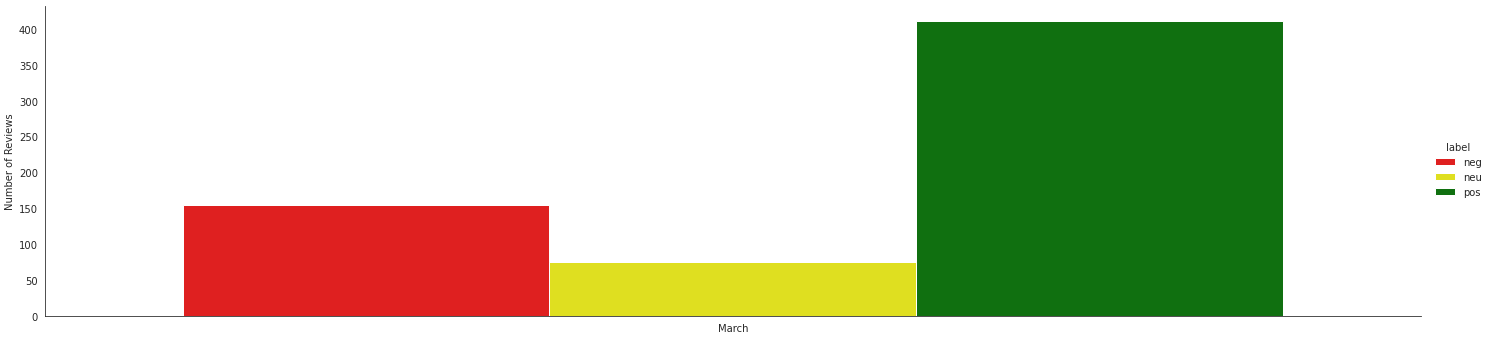

In [638]:
with sns.axes_style('white'):
    g = sns.factorplot("month", data=tesco_reviews, aspect=4.0, kind='count',
                       hue='label', order=range(3, 4), palette=['red','yellow','green'])
    g.set_ylabels('Number of Reviews')
    g.set_axis_labels("", "Number of Reviews")
    g.set_xticklabels(["March"])

In [644]:
tesco_reviews.loc[tesco_reviews['month'] == 3]['label'].value_counts()

pos    411
neg    155
neu     75
Name: label, dtype: int64

/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/carlosjperez/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


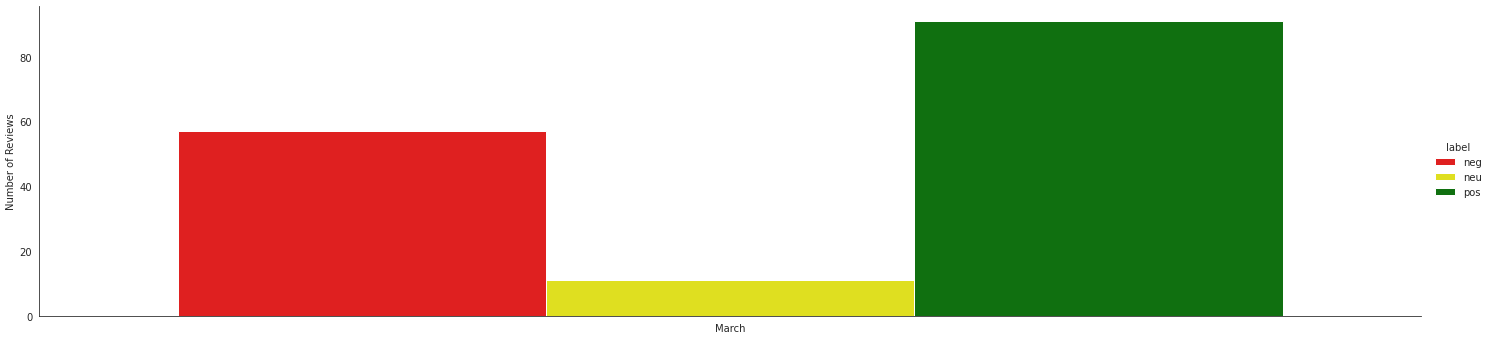

In [642]:
with sns.axes_style('white'):
    g = sns.factorplot("month", data=sainsburys_reviews, aspect=4.0, kind='count',
                       hue='label', order=range(3, 4), palette=['red','yellow','green'])
    g.set_ylabels('Number of Reviews')
    g.set_axis_labels("", "Number of Reviews")
    g.set_xticklabels(["March"])

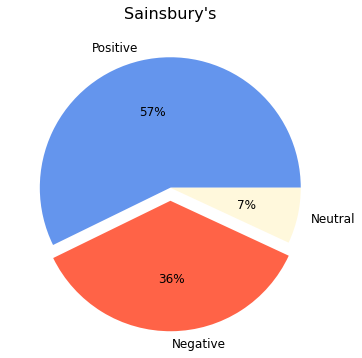

In [762]:
# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')

# create pie chart using matplotlib
def cm_to_inch(value):
    return value/2.54

explode = (0, 0.1, 0)  

fig = plt.figure(figsize=(6, 6))
plt.title("Sainsbury's", fontsize = 16)
_, _, autotexts = plt.pie(sainsburys_reviews.loc[sainsburys_reviews['month'] == 3]['label'].value_counts(), 
                          labels=['Positive', 'Negative', 'Neutral'], colors=['cornflowerblue', 'tomato', 'cornsilk'], 
                          autopct='%.0f%%', textprops={'fontsize': 12}, explode=explode)
for autotext in autotexts:
    autotext.set_color('black')
plt.show()

In [653]:
sainsburys_reviews.loc[sainsburys_reviews['month'] == 3]['label'].value_counts()

pos    91
neg    57
neu    11
Name: label, dtype: int64

In [841]:
sainsburys_reviews.loc[(sainsburys_reviews['year'] == 2022)]['reviewCreatedVersion'].value_counts()

2.57.1                       113
2.56.1                        75
3.0.1                         46
3.0.2                         14
3.0.0                         10
2.57.0                         2
2.45.1                         1
2.23.0                         1
2.40.2_SNAPSHOT_de6cc0715      1
2.44.0                         1
2.46.0                         1
2.47.2                         1
2.50.1                         1
Name: reviewCreatedVersion, dtype: int64